In [133]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

In [134]:
train_df = pd.read_csv('train.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [135]:
test_df = pd.read_csv('test.csv')
test_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [136]:
train_df.shape, test_df.shape

((1460, 81), (1459, 80))

In [137]:
combined_df = pd.concat([train_df, test_df], ignore_index=True)
combined_df.shape

(2919, 81)

In [138]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [139]:
combined_df['SalePrice'].head()

0    208500.0
1    181500.0
2    223500.0
3    140000.0
4    250000.0
Name: SalePrice, dtype: float64

In [140]:
combined_df['SalePrice'].tail()

2914   NaN
2915   NaN
2916   NaN
2917   NaN
2918   NaN
Name: SalePrice, dtype: float64

In [141]:
combined_df = combined_df.drop('Id', axis=1)

In [142]:
combined_df.isna().sum().sum()

17166

In [143]:
na_counts = combined_df.isna().sum()
na_counts = na_counts[na_counts>600]
na_counts

Alley          2721
MasVnrType     1766
FireplaceQu    1420
PoolQC         2909
Fence          2348
MiscFeature    2814
SalePrice      1459
dtype: int64

In [144]:
combined_df.drop(columns=['Alley','MasVnrType','FireplaceQu','PoolQC','Fence','MiscFeature'], axis=1, inplace=True)


In [145]:
na_counts = combined_df.isna().sum()
na_counts = na_counts[na_counts>0]
na_types = combined_df.dtypes[na_counts.index]
na_info = pd.DataFrame({
    'NaN Count': na_counts,
    'Data Type': na_types
})
na_info

,NaN Count,Data Type
MSZoning,4,object
LotFrontage,486,float64
Utilities,2,object
Exterior1st,1,object
Exterior2nd,1,object
MasVnrArea,23,float64
BsmtQual,81,object
BsmtCond,82,object
BsmtExposure,82,object
BsmtFinType1,79,object


In [146]:
combined_df['LotFrontage'].fillna(combined_df['LotFrontage'].mean(), inplace=True)
combined_df['MasVnrArea'].fillna(combined_df['MasVnrArea'].mean(), inplace=True)
combined_df['BsmtFinSF1'].fillna(combined_df['BsmtFinSF1'].mean(), inplace=True)
combined_df['BsmtFinSF2'].fillna(combined_df['BsmtFinSF2'].mean(), inplace=True)
combined_df['BsmtUnfSF'].fillna(combined_df['BsmtUnfSF'].mean(), inplace=True)
combined_df['TotalBsmtSF'].fillna(combined_df['TotalBsmtSF'].mean(), inplace=True)
combined_df['BsmtFullBath'].fillna(combined_df['BsmtFullBath'].mean(), inplace=True)
combined_df['BsmtHalfBath'].fillna(combined_df['BsmtHalfBath'].mean(), inplace=True)
combined_df['GarageCars'].fillna(combined_df['GarageCars'].mean(), inplace=True)
combined_df['GarageArea'].fillna(combined_df['GarageArea'].mean(), inplace=True)
combined_df['GarageYrBlt'].fillna(combined_df['GarageYrBlt'].mean(), inplace=True)

mode = combined_df['Electrical'].mode().iloc[0]
combined_df['Electrical'] = combined_df['Electrical'].fillna(mode)

na_counts = combined_df.isna().sum()
na_counts = na_counts[na_counts>0]
na_types = combined_df.dtypes[na_counts.index]
na_info = pd.DataFrame({
    'NaN Count': na_counts,
    'Data Type': na_types
})
na_info

,NaN Count,Data Type
MSZoning,4,object
Utilities,2,object
Exterior1st,1,object
Exterior2nd,1,object
BsmtQual,81,object
BsmtCond,82,object
BsmtExposure,82,object
BsmtFinType1,79,object
BsmtFinType2,80,object
KitchenQual,1,object


In [148]:
combined_df['SalePrice'].fillna(-1, inplace=True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   LotShape       2919 non-null   object 
 6   LandContour    2919 non-null   object 
 7   Utilities      2917 non-null   object 
 8   LotConfig      2919 non-null   object 
 9   LandSlope      2919 non-null   object 
 10  Neighborhood   2919 non-null   object 
 11  Condition1     2919 non-null   object 
 12  Condition2     2919 non-null   object 
 13  BldgType       2919 non-null   object 
 14  HouseStyle     2919 non-null   object 
 15  OverallQual    2919 non-null   int64  
 16  OverallCond    2919 non-null   int64  
 17  YearBuilt      2919 non-null   int64  
 18  YearRemo

In [149]:
# in case of no garage and no basement
combined_df.fillna('NA', inplace=True)
combined_df.isna().sum().sum()

0

In [150]:
categorical_features = combined_df.select_dtypes(include=['object']).columns
categorical_features

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [151]:
# Apply one-hot encoding to categorical features
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(combined_df[categorical_features])
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Concatenate the encoded features with the original DataFrame
combined_df = pd.concat([combined_df.drop(columns=categorical_features), encoded_df], axis=1)
combined_df.shape

/home/akshirsagar/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(2919, 283)

In [162]:
train_encoded = combined_df.iloc[:len(train_df)]
test_encoded = combined_df.iloc[len(train_df):]

test_encoded.drop(columns=['SalePrice'], inplace=True)

train_encoded.shape, test_encoded.shape

/tmp/ipykernel_10328/3350347100.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_encoded.drop(columns=['SalePrice'], inplace=True)


((1460, 283), (1459, 282))

In [163]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_encoded.drop(columns=['SalePrice']))
X_test_scaled = scaler.transform(test_encoded)

In [165]:
y = train_encoded['SalePrice'].values
x = X_train_scaled

In [166]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1168, 282), (1168,), (292, 282), (292,))

In [167]:
# Linear Regression: LR, 
# Ridge Regression: RR,
# Lasso Regression: LASSO,
# Decision Tree Regression: DTR,
# Random Forest Regression:RFR

# Mean Squared Error : MSE,
# Mean Absolute Error: MAE,
# Root Mean Squared Error: RMSE,
# R-squared:R2

models = {
    "LR": LinearRegression(),
    "RR": Ridge(),
    "LASSO": Lasso(),
    "DTR": DecisionTreeRegressor(),
    "RFR": RandomForestRegressor()
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "MAE": mae, "RMSE": rmse, "R2": r2}

# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame(results)
print(results_df)

/home/akshirsagar/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e+10, tolerance: 7.116e+08
  model = cd_fast.enet_coordinate_descent(


                LR            RR         LASSO           DTR           RFR
MSE   6.934732e+34  8.802646e+08  8.692095e+08  1.969669e+09  8.066762e+08
MAE   3.118709e+16  1.840969e+04  1.835629e+04  2.577071e+04  1.674539e+04
RMSE  2.633388e+17  2.966925e+04  2.948236e+04  4.438095e+04  2.840205e+04
R2   -9.723482e+24  8.765744e-01  8.781244e-01  7.238244e-01  8.868925e-01


In [168]:
df = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred
})
df

,y_test,y_pred
0,231500.0,213628.12
1,179500.0,163340.84
2,122000.0,118540.08
3,84500.0,81280.50
4,142000.0,151356.61
...,...,...
287,103200.0,96553.76
288,249700.0,248005.16
289,64500.0,106466.26
290,83000.0,101174.00


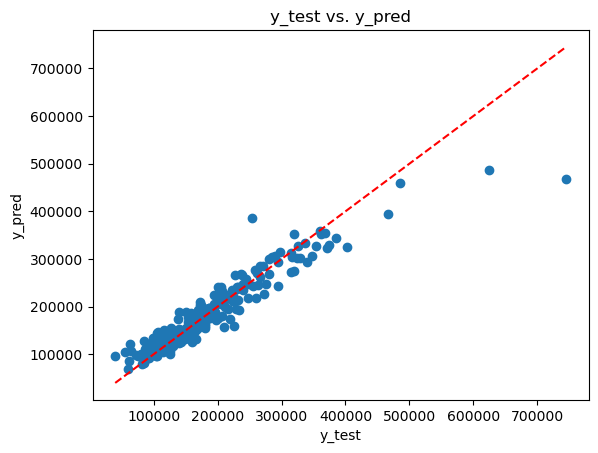

In [169]:
import matplotlib.pyplot as plt

# Scatter plot of y_test vs. y_pred
plt.scatter(df['y_test'], df['y_pred'])
plt.plot([df['y_test'].min(), df['y_test'].max()], [df['y_test'].min(), df['y_test'].max()], 'r--')  # Ideal line
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("y_test vs. y_pred")
plt.show()


In [170]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

result = {}
hyperparams = {}
result['default'] = {"MSE": mse, "MAE": mae, "RMSE": rmse, "R2": r2}
hyperparams['default'] = model.get_params()

In [177]:
# model = RandomForestRegressor(n_estimators=90, 
#                               max_depth=2,
#                               min_samples_split=,
#                               min_samples_leaf=,
#                               max_features=
#                              )
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# r2 = r2_score(y_test, y_pred)
# result['finetuned'] = {"MSE": mse, "MAE": mae, "RMSE": rmse, "R2": r2}
# results_df = pd.DataFrame(result)
# print(results_df)

SyntaxError: invalid syntax (3374857756.py, line 3)

In [171]:
from sklearn.model_selection import GridSearchCV

rfr = RandomForestRegressor()

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Set up the GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV to your training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best hyperparameters:", best_params)

/home/akshirsagar/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/home/akshirsagar/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/akshirsagar/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/home/akshirsagar/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_cons

Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [172]:
model1 = RandomForestRegressor(**best_params)
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
result['finetuned'] = {"MSE": mse, "MAE": mae, "RMSE": rmse, "R2": r2}
results_df = pd.DataFrame(result)
print(results_df)

           default     finetuned
MSE   7.942754e+08  9.787004e+08
MAE   1.680489e+04  1.718445e+04
RMSE  2.818289e+04  3.128419e+04
R2    8.886313e-01  8.627723e-01


In [173]:
hyperparams['finetuned'] = model1.get_params()
hyperparams_df = pd.DataFrame(hyperparams)
hyperparams_df

,default,finetuned
bootstrap,True,True
ccp_alpha,0.0,0.0
criterion,squared_error,squared_error
max_depth,None,None
max_features,1.0,sqrt
max_leaf_nodes,None,None
max_samples,None,None
min_impurity_decrease,0.0,0.0
min_samples_leaf,1,1
min_samples_split,2,2


In [174]:
y_pred = model.predict(X_test_scaled)

In [176]:
y_pred.shape

(1459,)

In [177]:
predicted_prices = pd.DataFrame({"Id": test_df.Id,'SalePrice': y_pred[0]})
predicted_prices

,Id,SalePrice
0,1461,128593.84
1,1462,128593.84
2,1463,128593.84
3,1464,128593.84
4,1465,128593.84
...,...,...
1454,2915,128593.84
1455,2916,128593.84
1456,2917,128593.84
1457,2918,128593.84


In [178]:
predicted_prices.to_csv("house_price_predictions.csv", header=True, index=False)